# Global Wheat Detection - Object Detection Using MMDetection Toolbox
### Training a DetectoRS Detector

By Reynaldo Vazquez<br>
November, 2020

This notebook uses the Pytorch-based [MMDetection]() toolbox to train neural network models that detect wheat heads from images of wheat plants. The data used comes from the [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection) competition provided by [The Global Institute for Food Security (GIFS)]( https://www.gifs.ca/) at the University of Saskatchewan (USask). 

The notebook has been set up to train 3 types of detectors, they all require a GPU for training.
1. Faster RCNN 50 (Ren et al., 2017) <br>[![Open In Colab](https://img.shields.io/badge/Open%20in%20Colab-Faster%20RCNN%2050-yellow?style=flat-square)](https://githubtocolab.com/reyvaz/Wheat-Heads-Object-Detectors/blob/master/global_wheat_detection_faster_rcnn.ipynb) 
2. DetectoRS (Qiao et al., 2020) 
3. Generalized Focal Loss (Li et al., 2020) <br>[![Open In Colab](https://img.shields.io/badge/Open%20in%20Colab-Generalized%20Focal%20Loss-yellow?style=flat-square)](https://githubtocolab.com/reyvaz/Wheat-Heads-Object-Detectors/blob/master/global_wheat_detection_gfl.ipynb) 


This notebook in particular shows the training and results of the **DetectoRS** detector. The other two are available at the Colab links listed above. 

Experimenting with various parameter settings and data pipelines I achieved better results with the Generalized Focal Loss and DetectoRS models (in that order), but the Faster RCNN 50 achieved good results much faster and it is much lighter weight. Additionally, the Faster RCNN 50 can be used for inference using either a CPU or a GPU, while the other 2 require a GPU.

To train the detectors I have created a set of annotation files both in Pascal VOC (xml) and in COCO (json) format, and are available (along with the code used to create them) [in this repo](https://github.com/reyvaz/Global-Wheat-XML-and-COCO-Annotations). Training in this notebook uses only the COCO style annotations, however I have set up both file systems so that either can be used. Some of the VOC files are required for the visualization utils. 

**Reproducing the Notebook**

To reproduce this notebook it is required that the `global-wheat-detection.zip` file containing the data be available in the `\content` directory. Due to usage terms I have agreed to, I am not able to share this file, however, it can be obtained [here]( https://www.kaggle.com/c/global-wheat-detection/data).



# Setup 

Install MMDetection ans supporting libraries

The mmcv library needs to be installed previous to installing mmdet. Select a mmcv version compatible with the torch, and cuda versions. 

In [ ]:
#@markdown Setting up MMDetection. 
setup_installations =  True #@p aram {type:"boolean"}
import sys, os

if not os.getcwd() == '/content':
    %cd /content
mmdet_exists = os.path.isdir('mmdetection')

if setup_installations and not mmdet_exists:
    print('Installing packages')
    !pip install mmcv-full==latest+torch1.7.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html --quiet
    #!pip install mmcv-full==1.2.0+torch1.7.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html
    !pip install -U albumentations --quiet
    !apt-get install tree -qq
    !pip install -U 'git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools' --quiet 
    !git clone https://github.com/open-mmlab/mmdetection.git --quiet
    %cd mmdetection
    #!git checkout 01f1d42 # may use sha version printed in environment versions
    !pip install -e . --quiet
else:
    print('Packages already installed')
    %cd mmdetection

Installing packages
     |████████████████████████████████| 19.8MB 7.5MB/s 
     |████████████████████████████████| 194kB 14.0MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 952kB 24.5MB/s 
     |████████████████████████████████| 36.7MB 69kB/s 
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content/mmdetection


Import Libraries

In [ ]:
import re, time, glob, sys, os, subprocess
import PIL, pycocotools, torch, torchvision
import os.path as osp
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
%matplotlib inline

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import skimage.io
import pylab
from datetime import datetime

import mmdet, mmcv
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.apis import set_random_seed, train_detector, inference_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmcv import Config

pylab.rcParams['figure.figsize'] = (7, 7)

In [ ]:
#@markdown Environment
print('mmcv version: {}'.format(mmcv.__version__))
mmdet_sha=subprocess.Popen('git log -1 --abbrev-commit --pretty="%h"', # mmdetection commit sha ID
                           shell=True, stdout=subprocess.PIPE).communicate()[0]
print('mmdet version: {}'.format(mmdet.__version__))
print('mmdet commit sha: {}'.format(mmdet_sha.decode("utf-8")))
print('PIL version', PIL.__version__)
print('pycocotools version', pycocotools.__version__)
print('torch version: {}, \ntorchvision version: {}'.format(
    torch.__version__, torchvision.__version__))
print('CUDA available: ', torch.cuda.is_available())
# Check nvcc version
print('\nNVCC version:')
!nvcc -V
print('\nGCC version:')
!gcc --version
#!git log -1 --abbrev-commit --pretty="%h"

mmcv version: 1.2.0
mmdet version: 2.6.0
mmdet commit sha: 01f1d42

PIL version 7.0.0
pycocotools version 12.0.2
torch version: 1.7.0+cu101, 
torchvision version: 0.8.1+cu101
CUDA available:  True

NVCC version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243

GCC version:
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Data Preparation

The code below downloads the annotation files from the [github repository](https://github.com/reyvaz/Global-Wheat-XML-and-COCO-Annotations). 

The `global-wheat-detection.zip` file needs to be manually placed in the `\content` directory. This file can be obtained [here]( https://www.kaggle.com/c/global-wheat-detection/data).

The image and annotation files will be arranged following the COCO file and naming structure. 




In [ ]:
#@markdown Verifying data and downloading annotation files
if not os.getcwd() == '/content':
    %cd /content

annotations_zip = 'annotations.zip'
annot_exist = os.path.isfile(annotations_zip)

if not annot_exist:
    !wget -q https://github.com/reyvaz/Global-Wheat-XML-and-COCO-Annotations/raw/master/data/annotations.zip

data_exists = os.path.isfile('global-wheat-detection.zip')
assert data_exists, 'global-wheat-detection.zip not found, it can be obtained '\
                    + 'at https://www.kaggle.com/c/global-wheat-detection/data'

/content


In [ ]:
#@markdown Extracting and arranging files
set_up_data = True #@param {type:"boolean"}
rebuild_data = False #@param {type:"boolean"}
if rebuild_data:
    %cd /content
    !rm -r data
    !rm -r mmdetection/data

data_exists = os.path.isdir('/content/data')

if set_up_data and not data_exists:
    %cd /content
    !mkdir data
    !unzip -q {annotations_zip} -d data
    !unzip -q global-wheat-detection.zip -d data
    !mkdir -p mmdetection/data/coco/annotations/
    !mkdir -p mmdetection/data/coco_annotations/
    !mv data/annotations/coco/* mmdetection/data/coco_annotations

    !mkdir -p mmdetection/data/VOCdevkit/VOC2007/ImageSets/Main/
    !mv data/annotations/*.txt mmdetection/data/VOCdevkit/VOC2007/ImageSets/Main/
    !mv /content/data/annotations/xml_annotations mmdetection/data/VOCdevkit/VOC2007/Annotations
    !mv data/test/* data/train
    !rm -r data/test
    !mv data/train data/images

coco_images_path = '/content/mmdetection/data/coco/train2017'

!mv /content/data/images {coco_images_path}
im_loc = coco_images_path

# The files (ids) below correspod to the 90-10 partition. These are only used
# to retrieve ids for plotting (and evaluation demo) purposes. Refer to 
# !ls /content/mmdetection/data/VOCdevkit/VOC2007/ImageSets/Main/) to use other 
# partitions. The val_ids here are always val, although they do not include all
# val images when using the 80-20 partition. For practical purposes this code 
# suffices.
val_file = '/content/mmdetection/data/VOCdevkit/VOC2007/ImageSets/Main/valid_ids_10.txt'
train_file = '/content/mmdetection/data/VOCdevkit/VOC2007/ImageSets/Main/train_ids_90.txt'
val_ids = [line.rstrip('\n') for line in open(val_file)]
train_ids = [line.rstrip('\n') for line in open(train_file)]

def list_to_text_file(id_list, dest_path):
    with open(dest_path, 'w') as f: 
        for item in id_list:
            f.write("%s\n" % item) 
    return None

print("Current image location: ", im_loc)

/content
Current image location:  /content/mmdetection/data/coco/train2017


Separate COCO format json files with different train/validation splits. 80-20, 90-10, and 90_plus-10 are available. The "plus" means that the train split contains images with no bb-boxes, that is, those images do not contain any of the relevant objects. 

In [ ]:
#@markdown Select train-validation split {run: "auto"}
train_val_split = '90_plus-10' #@param ['90-10', '90_plus-10', '80-20']

%cd /content/mmdetection
train_json = 'data/coco/annotations/instances_train2017.json'
val_json = 'data/coco/annotations/instances_val2017.json'

if os.path.isfile(train_json):
    !rm {train_json} {val_json}

if train_val_split == '90-10':
    !cp data/coco_annotations/train_90.json {train_json}
    !cp data/coco_annotations/val_10.json {val_json}
elif train_val_split == '90plus-10':
    !cp data/coco_annotations/train_90_plus.json {train_json}
    !cp data/coco_annotations/val_10.json {val_json}
else:
    !cp data/coco_annotations/train_80.json {train_json}
    !cp data/coco_annotations/val_20.json {val_json}

get_img_path = lambda x: im_loc +'/' + ids[x] + '.jpg'
my_dataset_root = 'data/'+im_loc.split('/')[4]

print('\n\nCoco File Structure\n')
!tree {my_dataset_root} --filelimit 10

/content/mmdetection


Coco File Structure

data/coco
├── annotations
│   ├── instances_train2017.json
│   └── instances_val2017.json
└── train2017 [3432 entries exceeds filelimit, not opening dir]

2 directories, 2 files


In [ ]:
#@markdown Collecting metadata (COCO indexing)<br>  
#@markdown used for visualization and evaluation, not required for training.

#@markdown - Retrieve annotations
#@markdown - COCO visualization
#@markdown - COCO image id look up (from filename stem)

dataDir="/content/mmdetection/data/coco"
annFile_train='{}/annotations/instances_train2017.json'.format(dataDir)
annFile_val='{}/annotations/instances_val2017.json'.format(dataDir)

coco_train=COCO(annFile_train)
print('\n')
coco_val=COCO(annFile_val)
print('\n')

cats = coco_train.loadCats(coco_train.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: {}\n'.format(' '.join(nms)))

catIds = coco_train.getCatIds(catNms=['wheat'])

imgIds_train = coco_train.getImgIds(catIds=1)
imgIds_val = coco_val.getImgIds(catIds=1)

def get_ground_truth_anns(coco_img_id, coco = coco_val):
    annIds = coco.getAnnIds(imgIds=coco_img_id, catIds=1)
    anns = coco.loadAnns(annIds)
    return anns

def get_bboxes(anns):
    bboxes = [a['bbox'] for a in anns]
    return bboxes

# Uses the cocotools built in annotation plotting
def plot_ground_truth(idx, img_dir, coco = coco_val, size = 5,
                      imgIds = imgIds_val, draw_bbox = False):
    # used for sanity check of the COCO dataset.
    # idx is the index of the order of appearance in imgIds. Not the coco index of the image.
    img = coco.loadImgs(imgIds[idx])[0]
    path = '{}/{}'.format(img_dir, img['file_name'])       
    I = skimage.io.imread(path)
    anns = get_ground_truth_anns(img['id'], coco)
    plt.figure(figsize=(size, size))
    plt.imshow(I); plt.axis('off')
    coco.showAnns(anns, draw_bbox=draw_bbox)
    return None

# Building the look up dictionary mapping coco id and image file name stems
img_val = coco_val.loadImgs(imgIds_val)
img_train = coco_train.loadImgs(imgIds_train)
df1 = pd.DataFrame(img_val)
df2 = pd.DataFrame(img_train)
df1.shape, df2.shape
df = pd.concat([df2, df1])
df = df[['file_name', 'id']]
df['file_id'] = [fname.split('.')[0] for fname in  df['file_name']]
id_look_up = pd.Series(df.id.values, index=df.file_id).to_dict()

stem_look_up = pd.Series(df.file_id.values, index=df.id).to_dict()

fnames = glob.glob(im_loc+'/*.jpg')
ids = [fn.split('/')[-1].split('.')[0] for fn in fnames]

## Start Older visualization fns
def show_image_from(input, from_file = True):
    # if false, its from array
    if from_file:
        input = Image.open(input)
    plt.figure(figsize=(5, 5))
    plt.imshow(input)
    plt.axis('off')
    plt.show()
    return None

# reference: https://nbviewer.jupyter.org/github/cocodataset/
#            cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb



loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


COCO categories: wheat



## Data Visualization

In [ ]:
#@markdown Visualization Utils (Ground Truth)

def bbox(img, xmin, ymin, xmax, ymax, color, width):
    draw = ImageDraw.Draw(img)
    box = [xmin, ymin, xmax, ymax]
    draw.rectangle(box, outline=color, width=width)

def plot_img_bboxes(img_id, img_dir, coco = coco_val, 
                    color = 'white', fig_size = None, coco_id = True):
    # Plots the ground truth
    if not coco_id:
        img_id = id_look_up[img_id]
    ans = get_ground_truth_anns(img_id)
    bboxes = get_bboxes(ans)
    img = coco.loadImgs(img_id)[0]
    path = '{}/{}'.format(img_dir, img['file_name'])  
    img = Image.open(path)
    _ = [bbox(img, bb[0], bb[1], bb[2] + bb[0], bb[3]+bb[1], color, 5) for bb in bboxes]
    if fig_size:
        plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(img)
    plt.axis('off')

def plot_list(im_loc, list_of_ids = None, coco = coco_val, coco_id = True):
    # coco_ids whether the ID refers to the json image id, or the file name stem. 
    if not list_of_ids:
        randind = np.random.randint(0, len(imgIds_val)-4)
        list_of_ids = imgIds_val[randind:randind+4]
        coco = coco_val
    if not coco_id: list_of_ids = [id_look_up[id] for id in list_of_ids]

    fig = plt.figure(figsize=(20, 10))
    idx=1
    for coco_img_id in list_of_ids:
        axes = fig.add_subplot(np.ceil(len(list_of_ids)/4), 4, idx)
        plot_img_bboxes(coco_img_id, im_loc, coco)
        idx=idx+1


In [ ]:
#@markdown Prediction Evaluation and Visualization Utils

font_dir = '/usr/share/fonts/truetype/liberation/' # font dir in colab, verify Kaggle
font_path = font_dir + 'LiberationSans-Bold.ttf'
fnt = ImageFont.truetype(font_path, 30)

def bbox_prob(img, xmin, ymin, xmax, ymax, 
              prob, thresh = 0.3, color = 'yellow', width = 5):
    # writes the probability from the results in the bbox
    # but only if prob > thresh
    if prob >= thresh:
        draw = ImageDraw.Draw(img)
        box = [xmin, ymin, xmax, ymax]
        draw.rectangle(box, outline=color, width=width)
        draw.text((xmax-46,ymax-34), 
                '{:.2f}'.format(prob).replace("0.",".")[:3], font = fnt)
    else: pass

def plot_preds(img_id, results, img_dir=im_loc, thresh = 0.3, coco = coco_val, 
                    color = 'white', fig_size = None, coco_id = False):
    # plots predictions from mmdet results. 
    # img_id can be from coco img ids or file name stem but needs to be specified
    # by coco_id. img_dir (is a legacy arg) always choose im_loc.
    # fig_size use None if using for multiplot.
    if not coco_id:
        img_id = id_look_up[img_id]
    bboxes = results[0].tolist()
    img = coco.loadImgs(img_id)[0]
    path = '{}/{}'.format(img_dir, img['file_name'])  
    img = Image.open(path)
    _ = [bbox_prob(img, bb[0], bb[1], bb[2] + bb[0], bb[3]+bb[1], bb[4], thresh,
                   color, 4) for bb in bboxes]
    if fig_size:
        plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(img)
    plt.axis('off')


def eval_summary(img_id, results, coco = coco_val, coco_id = False):
    if not coco_id: img_id = id_look_up[img_id]
    annType = 'bbox'
    my_results = []
    for bbox in results[0]:
        image_data = {
            'image_id': img_id,
            'bbox':  [int(b) for b in bbox[:4]],
            'score': bbox[4],
            'category_id': 1,
        }
        my_results.append(image_data)
    cocoDt = coco.loadRes(my_results)
    cocoEval = COCOeval(coco, cocoDt, annType)
    cocoEval.params.imgIds  = img_id
    cocoEval.evaluate()
    cocoEval.accumulate()
    #summary = cocoEval.summarize()
    return cocoEval

fontdict = {'fontsize' :18, 'color': '#b3b3b3'}

def ground_truth_vs_pred(im_id, result_coco, summary, 
                         im_loc=im_loc, coco = coco_val, 
                         coco_id = False, f_size = (15, 7), thresh = 0.3, 
                         color_preds = 'yellow', color_gt = 'white'):

    fig = plt.figure(figsize=f_size)
    axes = fig.add_subplot(1, 2, 1)
    plot_img_bboxes(im_id, im_loc, # plots ground truth
                coco, color_gt, coco_id = coco_id)
    plt.title('Ground Truth', fontdict = fontdict)
    axes = fig.add_subplot(1, 2, 2)
    plot_preds(im_id, result_coco, im_loc,  thresh, coco,  # plots predictions
                    color_preds, coco_id = coco_id)
    plt.title('Prediction', fontdict = fontdict)
    print('Prediction Metrics for this Image:')
    print(' AP @ [IoU=0.50:0.95] = {}'.format(summary[0]))
    print(' AP @ [IoU=0.50     ] = {}\n'.format(summary[1]))
    return None

def max_to_dist(bbox):
    # transforms x_max and y_max to x_dist and y_dist
    # to make mmdet results compatible with COCO tools
    bbox[2] = bbox[2] - bbox[0]
    bbox[3] = bbox[3] - bbox[1]
    return bbox

def mmdet_result_to_coco(result):
    # arg: result is the output from inference from a mmdet model
    # returns: results compatible with COCO functions
    result_coco = np.copy(result)
    result_coco = [max_to_dist(bbox) for bbox in result_coco[0]]
    return [np.array(result_coco)]



In [ ]:
#@markdown Main inference function
def pred_vs_gt(im_id, model, coco = coco_val, coco_id = False):
    if coco_id: im_id = stem_look_up[img_id]
    img_path = im_loc +'/'+ im_id + '.jpg'
    result_mmdet = inference_detector(model, img_path)
    result_coco = mmdet_result_to_coco(np.copy(result_mmdet))
    eval = eval_summary(im_id, result_coco, coco, coco_id = coco_id)
    eval.summarize()
    summary = eval.stats
    return result_coco, summary


## Plots. 



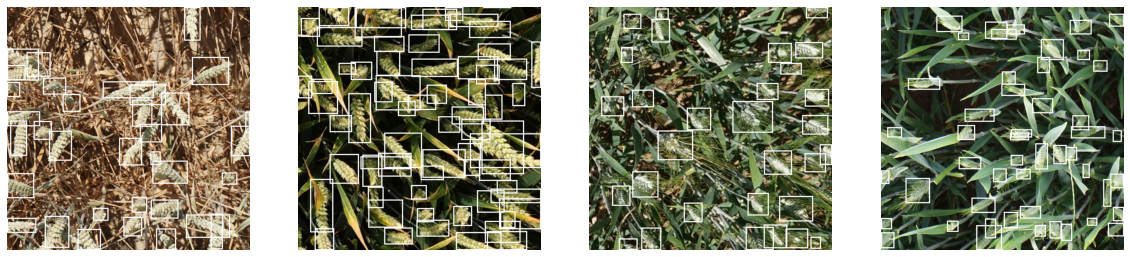

In [ ]:
plot_list(im_loc, coco = coco_train)

In [ ]:
#@markdown other plotting function examples
# plot_list(im_loc, coco = coco_train) # display a random set of train images
# coco_img_id = imgIds_val[11] # Using Coco Image ID
# plot_img_bboxes(coco_img_id, im_loc, coco = coco_val, fig_size = 5)
# im_id = val_ids[30] # using file stem IDs
# plot_img_bboxes(im_id, im_loc, coco = coco_val, fig_size = 5, coco_id=False)
# im_ids = val_ids[30:34] # display images from image file name stem
# plot_list(im_loc, im_ids, coco_id=False)
# idx = -1
# idx += 1
# plot_ground_truth(idx, im_loc, draw_bbox = False)

## Checkpoints and Configuration Files. 

Below are the configurations and checkpoint for the 3 types of detectors. Simply choose a `detector_type`. 

Select `pretrained_weights = COCO` to get a "fresh" start with the weights pretrained on the COCO dataset only. Select `pretrained_weights = WHEAT` to start with weights that have additionally been trained on the wheat dataset for a few epochs. 

Additional detectors can be found [here](https://github.com/open-mmlab/mmdetection/tree/master/configs). 

In [ ]:
#@title Detector config and checkpoint paths/files

#@markdown Choose detector and pretrained weights
detector_type = 'Cascade DetectoRS' #@param ['Faster RCNN 50', 'Cascade DetectoRS', 'Generalized Focal Loss']
pretrained_weights = 'WHEAT' #@param ['COCO', 'WHEAT']

url_prefix = ' http://download.openmmlab.com/mmdetection/v2.0/'

if not os.getcwd() == '/content/mmdetection':
    %cd '/content/mmdetection'

mmcv.mkdir_or_exist('checkpoints')
# checkpoint refers to the (destination) local path for pretrained weights. 

if detector_type == 'Faster RCNN 50':
    config_path = './configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
    if pretrained_weights == 'COCO':
        checkpoint_fname = 'faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
        checkpoint = 'checkpoints/' + checkpoint_fname
        checkpoint_url = url_prefix + 'faster_rcnn/faster_rcnn_r50_fpn_1x_coco/' + checkpoint_fname
    else:
        checkpoint = 'checkpoints/' + 'checkpoint_faster_rcnn_wheat.pth'
        checkpoint_drive_id = '1-6fARlRnK8xJrWj5R_zxO3a4GvICagh5'

if detector_type == 'Cascade DetectoRS':
    config_path = 'configs/detectors/detectors_cascade_rcnn_r50_1x_coco.py' 
    if pretrained_weights == 'COCO':
        checkpoint_fname = 'detectors_cascade_rcnn_r50_1x_coco-32a10ba0.pth'
        checkpoint = 'checkpoints/' + checkpoint_fname
        checkpoint_url = url_prefix + 'detectors/detectors_cascade_rcnn_r50_1x_coco/' + checkpoint_fname
    else:
        checkpoint = 'checkpoints/' + 'checkpoint_detectors_wheat.pth'
        checkpoint_drive_id = '1-9yb3eU7IJr7AGA0FfCNNVCq_QeABYNQ'
    
if detector_type == 'Generalized Focal Loss':
    config_path = 'configs/gfl/gfl_r101_fpn_dconv_c3-c5_mstrain_2x_coco.py' 
    if pretrained_weights == 'COCO':
        checkpoint_fname = 'gfl_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20200630_102002-134b07df.pth'
        checkpoint = 'checkpoints/' + checkpoint_fname
        checkpoint_url = url_prefix + 'gfl/gfl_r101_fpn_dconv_c3-c5_mstrain_2x_coco/' + checkpoint_fname
    else:
        checkpoint = 'checkpoints/' + 'checkpoint_gfl_wheat.pth'
        checkpoint_drive_id = '1-5MCSwkX8LC7tvbGsSd0UmtpsPWXXf1t'

if pretrained_weights == 'COCO' and not os.path.isfile(checkpoint):
    !wget {checkpoint_url} -O {checkpoint}
    resume_from = None
if pretrained_weights == 'WHEAT' and not os.path.isfile(checkpoint):
    !gdown -q https://drive.google.com/uc?id={checkpoint_drive_id} -O {checkpoint}
    resume_from = checkpoint

assert os.path.isfile(checkpoint), 'checkpoint file is missing'
assert os.path.isfile(config_path), 'configuration file is missing, verify path'
print('Configurtaion path: ', config_path)
print('Checkpoint path:    ', checkpoint)

Configurtaion path:  configs/detectors/detectors_cascade_rcnn_r50_1x_coco.py
Checkpoint path:     checkpoints/checkpoint_detectors_wheat.pth


Register custom dataset

In [ ]:
if not 'MyCocoDataset' in DATASETS._module_dict:
    @DATASETS.register_module('MyCocoDataset')
    class MyCocoDataset(CocoDataset): # important to specify CLASSES = (['w']) as a list
        CLASSES = (['wheat'])
# DATASETS._module_dict # uncomment to see registered datasets

## Editing Configiguration

Use `print(cfg.pretty_text)` to see all detector's configuration options. 

Need to update the dataset type to the custom dataset registered above and specify the paths to the data files. 

Here all images are in the same directory. The json files will instruct about the data train/validation partition and retrieve the images from this directory.

Also, the configured is originally set to the 80 COCO number of classes. We need to edit to configuration to 1 class (wheat). 

In [ ]:
cfg = Config.fromfile(config_path)
my_num_classes = 1
# print(cfg.pretty_text) # uncomment to render the configuration

In [ ]:
my_dataset_type = 'MyCocoDataset'
my_dataset_root = 'data/coco/'
cfg.data.val.img_prefix =  'data/coco/train2017/' # all images are in same dir
cfg.data.test.img_prefix = 'data/coco/train2017/'
    
if detector_type == 'Cascade DetectoRS': 
    for i in range(3): cfg.model.roi_head.bbox_head[i].num_classes = my_num_classes
elif detector_type == 'Generalized Focal Loss':
    cfg.model.bbox_head.num_classes = my_num_classes
else: # i.e. faster rcnn etc.
    cfg.model.roi_head.bbox_head.num_classes = my_num_classes

cfg.dataset_type = cfg.data.train.type = cfg.data.val.type = cfg.data.test.type = my_dataset_type

The hidden code below contains some of the data pipeline options that can be edited. This notebook uses the default data pipeline configuration.

In [ ]:
#@markdown example of data pipeline editing (i.e. image scale, augmentations)
if False:
    train_img_scale= [(1333, 480), (1333, 800)] 
    train_pipeline = [
        dict(type='LoadImageFromFile', to_float32=True), 
        # above, "to_float32=True" required by PhotoMetricDistortion, False otherwise
        dict(type='LoadAnnotations', with_bbox=True),
        dict(
            type='Resize',
            img_scale=train_img_scale,
            multiscale_mode='range',
            keep_ratio=True),
        # dict(type='RandomCrop', crop_size=(512, 512)),
        # dict(type='RandomCenterCropPad', crop_size=(512, 512)),
        # dict(type='PhotoMetricDistortion'),

        dict(type='RandomFlip', flip_ratio=0.5),
        dict(type='RandomFlip', flip_ratio=0.25, direction = 'vertical'),
        dict(
            type='Normalize',
            mean=[123.675, 116.28, 103.53],
            std=[58.395, 57.12, 57.375],
            to_rgb=True),
        dict(type='Pad', size_divisor=32),
        dict(type='DefaultFormatBundle'),
        dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
    ]

    cfg.data.train.pipeline = train_pipeline
    cfg.data.train.pipeline

### Optimizer, Learning Rate, Epochs.



In [ ]:
cfg.load_from = checkpoint 
cfg.resume_from = resume_from 
# resume_from is defined at the "Checkpoints and Config Files" section. If using
# weights pretrained using the wheat dataset use resume_from = checkpoint to 
# resume epoch dependent variables such as the learning rate schedule.

cfg.work_dir = './output' # Set up working dir to save files and logs.
cfg.optimizer.lr = 0.0027 # The original LR = 0.02 is set for 8-GPU. 
cfg.lr_config = {'policy': 'step', 'gamma': 1/3, 'step': [3, 6, 10, 13, 15], 'warmup': 'linear',  
                 'warmup_iters': 500, 'warmup_ratio': 0.001} # default gamma = 1/10
# LR=.0027 yields LR sched [2.7e-3, 9e-4, 3e-4, 1e-4, 3.3e-5, 1.1e-5] updating 
# at every 'step': [3, 6, 10, 13, 15]
cfg.log_config.interval = 100
cfg.evaluation.interval = 1 # set the evaluation frequency (epochs)
cfg.checkpoint_config.interval = 2 # Set the checkpoint saving interval
cfg.total_epochs = 8
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [ ]:
print('Optimizer settings:', cfg.optimizer)
print('Learning rate settings:', cfg.lr_config)
print('Learning rate:', cfg.optimizer.lr)
print('Epochs:', cfg.total_epochs)
print('Weights from:', cfg.load_from)
print('Resume from:', cfg.resume_from)

Optimizer settings: {'type': 'SGD', 'lr': 0.0027, 'momentum': 0.9, 'weight_decay': 0.0001}
Learning rate settings: {'policy': 'step', 'gamma': 0.3333333333333333, 'step': [3, 6, 10, 13, 15], 'warmup': 'linear', 'warmup_iters': 500, 'warmup_ratio': 0.001}
Learning rate: 0.0027
Epochs: 8
Weights from: checkpoints/checkpoint_detectors_wheat.pth
Resume from: checkpoints/checkpoint_detectors_wheat.pth


In [ ]:
# Create work_dir to save logs and output
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

Save config file

In [ ]:
conf_text = cfg.pretty_text
config_file = './output/my_config_{}.py'.format(detector_type.replace(' ', '_'))
with open(config_file, 'w') as f: 
    f.write(conf_text) 
#print(conf_text)

### Build dataset and model

In [ ]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [ ]:
# Build model
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES 

2020-11-18 04:23:49,375 - mmdet - INFO - load model from: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


2020-11-18 04:23:50,345 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offset_l.bias, layer2.2.conv2.weight_diff, layer2.2.conv2.switch.weight, layer2.2.conv2.switch.bias, layer2.2.conv2.pre_context.w

## Training

In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=True) 

2020-11-18 04:24:04,485 - mmdet - INFO - load checkpoint from checkpoints/checkpoint_detectors_wheat.pth


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


2020-11-18 04:24:04,966 - mmdet - INFO - resumed epoch 4, iter 5396
2020-11-18 04:24:04,968 - mmdet - INFO - Start running, host: root@b3cd2aa17e9b, work_dir: /content/mmdetection/output
2020-11-18 04:24:04,969 - mmdet - INFO - workflow: [('train', 1)], max: 8 epochs
2020-11-18 04:26:55,955 - mmdet - INFO - Epoch [5][100/1349]	lr: 9.000e-04, eta: 2:30:54, time: 1.710, data_time: 0.028, memory: 6532, loss_rpn_cls: 0.0277, loss_rpn_bbox: 0.0556, s0.loss_cls: 0.1596, s0.acc: 93.0703, s0.loss_bbox: 0.1737, s1.loss_cls: 0.0809, s1.acc: 93.0733, s1.loss_bbox: 0.2132, s2.loss_cls: 0.0502, s2.acc: 90.6593, s2.loss_bbox: 0.1268, loss: 0.8876
2020-11-18 04:29:45,454 - mmdet - INFO - Epoch [5][200/1349]	lr: 9.000e-04, eta: 2:27:25, time: 1.695, data_time: 0.005, memory: 6532, loss_rpn_cls: 0.0259, loss_rpn_bbox: 0.0475, s0.loss_cls: 0.1524, s0.acc: 93.2490, s0.loss_bbox: 0.1673, s1.loss_cls: 0.0754, s1.acc: 93.5114, s1.loss_bbox: 0.2054, s2.loss_cls: 0.0470, s2.acc: 91.3151, s2.loss_bbox: 0.1252,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 675/675, 3.7 task/s, elapsed: 184s, ETA:     0s

2020-11-18 05:05:17,805 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=42.48s).
Accumulating evaluation results...


2020-11-18 05:06:01,323 - mmdet - INFO - Epoch(val) [5][1349]	bbox_mAP: 0.5420, bbox_mAP_50: 0.9370, bbox_mAP_75: 0.5650, bbox_mAP_s: 0.1720, bbox_mAP_m: 0.5340, bbox_mAP_l: 0.5820, bbox_mAP_copypaste: 0.542 0.937 0.565 0.172 0.534 0.582


DONE (t=0.86s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.542
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.937
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.565
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.172
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.534
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.582
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.601
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.601
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.601
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.276
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.597
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.629


2020-11-18 05:08:53,418 - mmdet - INFO - Epoch [6][100/1349]	lr: 9.000e-04, eta: 1:47:54, time: 1.721, data_time: 0.027, memory: 6578, loss_rpn_cls: 0.0270, loss_rpn_bbox: 0.0518, s0.loss_cls: 0.1510, s0.acc: 93.4482, s0.loss_bbox: 0.1697, s1.loss_cls: 0.0771, s1.acc: 93.2457, s1.loss_bbox: 0.2106, s2.loss_cls: 0.0480, s2.acc: 91.1024, s2.loss_bbox: 0.1285, loss: 0.8637
2020-11-18 05:11:42,982 - mmdet - INFO - Epoch [6][200/1349]	lr: 9.000e-04, eta: 1:45:24, time: 1.696, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0231, loss_rpn_bbox: 0.0497, s0.loss_cls: 0.1513, s0.acc: 93.4238, s0.loss_bbox: 0.1632, s1.loss_cls: 0.0738, s1.acc: 93.6518, s1.loss_bbox: 0.2021, s2.loss_cls: 0.0467, s2.acc: 91.5410, s2.loss_bbox: 0.1245, loss: 0.8344
2020-11-18 05:14:32,513 - mmdet - INFO - Epoch [6][300/1349]	lr: 9.000e-04, eta: 1:42:51, time: 1.695, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0285, loss_rpn_bbox: 0.0535, s0.loss_cls: 0.1619, s0.acc: 92.9062, s0.loss_bbox: 0.1771, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 675/675, 3.7 task/s, elapsed: 184s, ETA:     0s

2020-11-18 05:47:18,402 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=42.54s).
Accumulating evaluation results...


2020-11-18 05:48:01,984 - mmdet - INFO - Epoch(val) [6][1349]	bbox_mAP: 0.5480, bbox_mAP_50: 0.9380, bbox_mAP_75: 0.5800, bbox_mAP_s: 0.1610, bbox_mAP_m: 0.5390, bbox_mAP_l: 0.5890, bbox_mAP_copypaste: 0.548 0.938 0.580 0.161 0.539 0.589


DONE (t=0.87s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.938
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.580
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.161
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.539
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.589
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.605
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.605
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.270
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.601
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.636


2020-11-18 05:50:53,796 - mmdet - INFO - Epoch [7][100/1349]	lr: 3.000e-04, eta: 1:10:54, time: 1.718, data_time: 0.027, memory: 6578, loss_rpn_cls: 0.0246, loss_rpn_bbox: 0.0509, s0.loss_cls: 0.1563, s0.acc: 93.1670, s0.loss_bbox: 0.1616, s1.loss_cls: 0.0754, s1.acc: 93.4853, s1.loss_bbox: 0.2074, s2.loss_cls: 0.0477, s2.acc: 91.3480, s2.loss_bbox: 0.1269, loss: 0.8508
2020-11-18 05:53:42,946 - mmdet - INFO - Epoch [7][200/1349]	lr: 3.000e-04, eta: 1:08:15, time: 1.691, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0234, loss_rpn_bbox: 0.0505, s0.loss_cls: 0.1553, s0.acc: 93.2363, s0.loss_bbox: 0.1679, s1.loss_cls: 0.0764, s1.acc: 93.3761, s1.loss_bbox: 0.2122, s2.loss_cls: 0.0480, s2.acc: 91.0664, s2.loss_bbox: 0.1296, loss: 0.8633
2020-11-18 05:56:32,428 - mmdet - INFO - Epoch [7][300/1349]	lr: 3.000e-04, eta: 1:05:36, time: 1.695, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0269, loss_rpn_bbox: 0.0506, s0.loss_cls: 0.1562, s0.acc: 93.2490, s0.loss_bbox: 0.1653, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 675/675, 3.6 task/s, elapsed: 185s, ETA:     0s

2020-11-18 06:29:17,826 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=42.91s).
Accumulating evaluation results...


2020-11-18 06:30:02,154 - mmdet - INFO - Epoch(val) [7][1349]	bbox_mAP: 0.5530, bbox_mAP_50: 0.9380, bbox_mAP_75: 0.5870, bbox_mAP_s: 0.1630, bbox_mAP_m: 0.5430, bbox_mAP_l: 0.5980, bbox_mAP_copypaste: 0.553 0.938 0.587 0.163 0.543 0.598


DONE (t=0.88s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.938
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.587
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.163
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.543
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.598
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.609
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.609
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.609
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.265
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.602
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.647


2020-11-18 06:32:54,418 - mmdet - INFO - Epoch [8][100/1349]	lr: 3.000e-04, eta: 0:34:04, time: 1.722, data_time: 0.028, memory: 6578, loss_rpn_cls: 0.0227, loss_rpn_bbox: 0.0485, s0.loss_cls: 0.1537, s0.acc: 93.3037, s0.loss_bbox: 0.1664, s1.loss_cls: 0.0736, s1.acc: 93.8594, s1.loss_bbox: 0.2134, s2.loss_cls: 0.0475, s2.acc: 91.3621, s2.loss_bbox: 0.1324, loss: 0.8583
2020-11-18 06:35:43,990 - mmdet - INFO - Epoch [8][200/1349]	lr: 3.000e-04, eta: 0:31:22, time: 1.696, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0220, loss_rpn_bbox: 0.0510, s0.loss_cls: 0.1575, s0.acc: 93.0781, s0.loss_bbox: 0.1722, s1.loss_cls: 0.0774, s1.acc: 93.3181, s1.loss_bbox: 0.2164, s2.loss_cls: 0.0493, s2.acc: 90.9497, s2.loss_bbox: 0.1291, loss: 0.8750
2020-11-18 06:38:33,721 - mmdet - INFO - Epoch [8][300/1349]	lr: 3.000e-04, eta: 0:28:40, time: 1.697, data_time: 0.005, memory: 6578, loss_rpn_cls: 0.0216, loss_rpn_bbox: 0.0497, s0.loss_cls: 0.1480, s0.acc: 93.5996, s0.loss_bbox: 0.1604, s1.loss_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 675/675, 3.7 task/s, elapsed: 184s, ETA:     0s

2020-11-18 07:11:21,536 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=41.25s).
Accumulating evaluation results...


2020-11-18 07:12:03,823 - mmdet - INFO - Epoch(val) [8][1349]	bbox_mAP: 0.5550, bbox_mAP_50: 0.9380, bbox_mAP_75: 0.5930, bbox_mAP_s: 0.1660, bbox_mAP_m: 0.5460, bbox_mAP_l: 0.5990, bbox_mAP_copypaste: 0.555 0.938 0.593 0.166 0.546 0.599


DONE (t=0.86s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.938
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.593
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.166
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.546
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.599
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.610
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.610
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.261
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.604
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.645


## Predictions Visualization and Evaluation

**Ground truth vs prediction (validation images)**


In [ ]:
model.cfg = cfg
idx = 10

In [ ]:
%%capture
idx += 1; im_id = val_ids[idx] 
result_coco, summary = pred_vs_gt(im_id, model, coco_id = False)

Prediction Metrics for this Image:
 AP @ [IoU=0.50:0.95] = 0.5375718015452329
 AP @ [IoU=0.50     ] = 0.9684411067453057



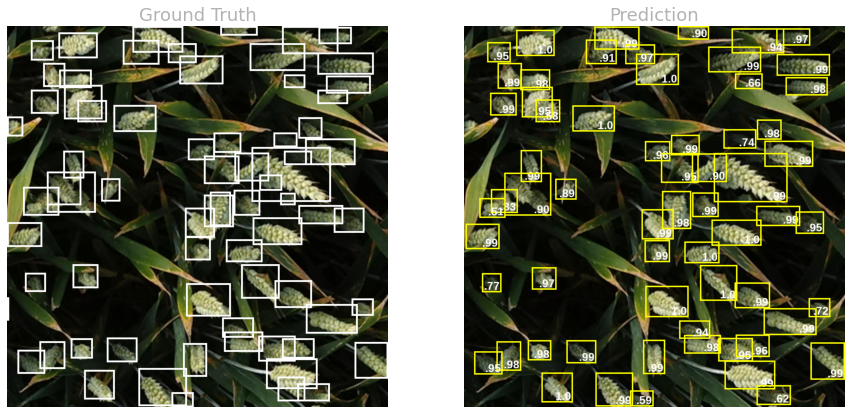

In [ ]:
ground_truth_vs_pred(im_id, result_coco, summary, im_loc, f_size = (15, 7), thresh = 0.5, 
                         color_preds = 'yellow', color_gt = 'white')

In [ ]:
%%capture
idx += 1; im_id = val_ids[idx] 
result_coco, summary = pred_vs_gt(im_id, model, coco_id = False)

Prediction Metrics for this Image:
 AP @ [IoU=0.50:0.95] = 0.5907379760888822
 AP @ [IoU=0.50     ] = 0.9501301662525694



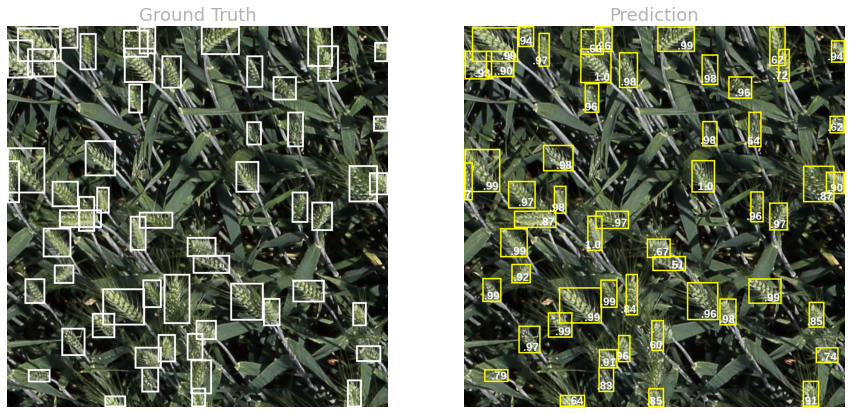

In [ ]:
ground_truth_vs_pred(im_id, result_coco, summary, im_loc, f_size = (15, 7), thresh = 0.5, 
                         color_preds = 'yellow', color_gt = 'white')

In [ ]:
%%capture
idx += 1; im_id = val_ids[idx] 
result_coco, summary = pred_vs_gt(im_id, model, coco_id = False)

Prediction Metrics for this Image:
 AP @ [IoU=0.50:0.95] = 0.63016977655366
 AP @ [IoU=0.50     ] = 0.9955009178729424



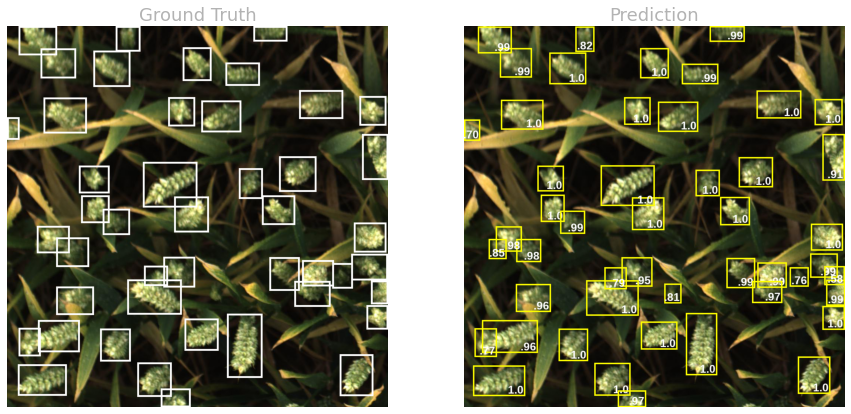

In [ ]:
ground_truth_vs_pred(im_id, result_coco, summary, im_loc, f_size = (15, 7), thresh = 0.5, 
                         color_preds = 'yellow', color_gt = 'white')

# References

**Chen, Kai et al**. "MMDetection: Open MMLab Detection Toolbox and Benchmark" arXiv preprint arXiv:1906.07155. (2019).

**David, Etienne., et al**. "Global Wheat Head Detection (GWHD) dataset: a large and diverse dataset of high resolution RGB labelled images to develop and benchmark wheat head detection methods". arXiv:2005.02162 [cs.CV]. (2020).

**Li, Xiang et al**. "Generalized Focal Loss: Learning Qualified and Distributed Bounding Boxes for Dense Object Detection". arXiv preprint arXiv:2006.04388. (2020).

**Qiao, Siyuan et al**. "DetectoRS: Detecting Objects with Recursive Feature Pyramid and Switchable Atrous Convolution". arXiv preprint arXiv:2006.02334. (2020).

**Ren, Shaoqing et al**. "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks". IEEE Transactions on Pattern Analysis and Machine Intelligence. (2017).






